# Explanation / Motivation:
- Study on non-discriminatory supervised learning models
- This data set is a case study on FICO scores and how they determine a 'threshold' cutoff score to either deny or approve a loan application
- Using data from the Federal Reserve, we can see the distribution of scores (FICO score percentile) against four main demographic groups: Asian, Hispanic, Black, and White
- With this data, we can plot the probability of defaulting and/or non-defaulting people from a specified demographpic group getting approved a loan ($\hat Y$ = 1).
- Theoretically, the probability of defaulting and/or non-defaulting people getting ($\hat Y$ = 1) should be equal amongst all demographic groups, but as you can see from this study, that is not the case.
- I dive into what this means in terms of precision/recall, the cost of these discrepencies, why this is happening, as well as methodologies for improvement.
- Data and non-descriminitaory model analysis courtesy of https://arxiv.org/pdf/1610.02413.pdf

In [9]:
from bs4 import BeautifulSoup
import fileinput
import sys
import re
import csv
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines


### Scraping Data from Federal Reserve:
#### Explanations / Guidelines:
- All files are saved in current directory
- We will be analyzing "Figure_7.D._TransRisk_Score_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Random-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv" and saving that file as 'random-account-ficoscores.csv' for easier reference
- To analyze the Cumulative Percentage of Goods and Bads for any of the other protected groups (sex, age, marital status, or income ratio) simply plug in this csv when assigning the 'data' variable
- Options for account types: any-account, new-account, existing-account, random-account
- In this study, "good" means non-defaulting for loans (will pay it off). "Bad" means defaulting for loans (will not pay it off).

In [10]:

url = "www.federalreserve.gov/boarddocs/rptcongress/creditscore/overviewfigtables.htm"
r  = requests.get("https://" +url)
data = r.text
soup = BeautifulSoup(data, 'lxml')


def cell_text(cell):
    return " ".join(cell.stripped_strings)

for table in soup.find_all('table'):
    title = table.find('span', { 'class' : 'tablehead' }).getText()
    subhead = table.find('span', { 'class' : 'tablesubheadsmall' }).getText()
    fname = (title + ' - '+subhead).replace(' ', '_') + '.csv'
    fname = fname.replace(':', '-')
    with open(fname, 'w') as outfile:
        output = csv.writer(outfile)

        for row in table.find_all('tr'):
            col = map(cell_text, row.find_all(re.compile('t[dh]')))
            output.writerow(col)
            

In [11]:
# os.rename('Figure_7.D._TransRisk_Score-_Cumulative_Percentage_of_Goods_and_Bads,_by_Demographic_Group(Random-Account_Performance)_-_Race_or_ethnicity_(SSA_data).csv', 'random-account-ficoscores.csv')

In [12]:
data = pd.read_csv("random-account-ficoscores.csv")
#Necessary to rename this column for clarity of the data it represents
#because of formatting issues when parsing data from the html
data.rename(columns={'Black (Bad).1':'Hispanic (Good)'}, inplace=True)

In [13]:
white_non_default = data[["Score", "Non- Hispanic white (Good)"]]
white_default = data[["Score","Non- Hispanic white (Bad)"]]
black_non_default = data[["Score","Black (Good)"]]
black_default = data[["Score","Black (Bad)"]]
hispanic_non_default = data[["Score","Hispanic (Good)"]]
hispanic_default = data[["Score","Hispanic (Bad)"]]
asian_non_default = data[["Score","Asian (Good)"]]
asian_default = data[["Score","Asian (Bad)"]]

In [7]:
def getGraph(dataset, metricName, graphType):
    i= 0
    x = []
    y = []
    while(i < 100.5):
        if(i == 72.5 or i == 77.5 or i == 92.5):
            i = (i + 0.5)
        curr_race_non_default = dataset[dataset["Score"] >= i][metricName].sum()
        total_race_non_default = dataset[metricName].sum()
        yVal = curr_race_non_default / total_race_non_default
        x.append(i)
        y.append(yVal)
        i = (i + 0.5)
    plt.plot(x, y, graphType, label=metricName)

## Visualizing This Data:
#### Now we have data for how many people are defaulters and non-defaulters for each score, theoretically the probability of a non-defaulter getting approved a loan ($\hat Y$ = 1) should be the same amongst all four groups. You can see from the graph that this is not the case: a person from the black demographic group is much less likely to be approved than a white or asian non-defaulting person.

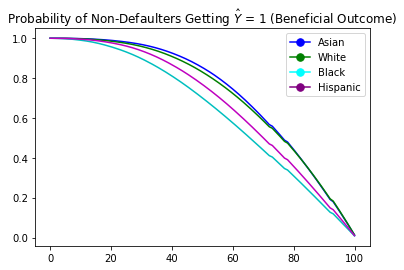

In [14]:
getGraph(asian_non_default, "Asian (Good)", 'b-')
getGraph(white_non_default, "Non- Hispanic white (Good)", 'g-')
getGraph(black_non_default, "Black (Good)", 'c-')
getGraph(hispanic_non_default, "Hispanic (Good)", 'm-')
plt.title("Probability of Non-Defaulters Getting $\hat Y$ = 1 (Beneficial Outcome)" )


blue_line = mlines.Line2D([], [], color='blue', marker='.',
                          markersize=15, label='Asian')
green_line = mlines.Line2D([], [], color='green', marker='.',
                          markersize=15, label='White')
cyan_line = mlines.Line2D([], [], color='cyan', marker='.',
                          markersize=15, label='Black')
purple_line = mlines.Line2D([], [], color='purple', marker='.',
                          markersize=15, label='Hispanic')

plt.legend(handles=[blue_line, green_line, cyan_line, purple_line])